# #8 Min-Variance Portfolio

1. 최소-분산 포트폴리오를 구하고 그래프로 그려본다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# import cvxopt as opt
# from cvxoppt import solvers
# solvers.options['show_progress'] = False

In [2]:
tickers = ['AAPL', 'GOOGL', 'AMZN']
df = yf.download(tickers, start='2019-01-01')['Adj Close']

ret = df.pct_change(1).dropna()
ret.head()

[*********************100%***********************]  3 of 3 completed


,AAPL,AMZN,GOOGL
Date,,,
2019-01-03,-0.099607,-0.025241,-0.027696
2019-01-04,0.042689,0.050064,0.051294
2019-01-07,-0.002226,0.034353,-0.001994
2019-01-08,0.019063,0.016612,0.008783
2019-01-09,0.016982,0.001714,-0.003427


In [3]:
ret_mtx = ret.values.T
ret_mtx

array([[-0.09960744,  0.0426892 , -0.00222581, ..., -0.00585988,
         0.00048668, -0.0056753 ],
       [-0.0252415 ,  0.050064  ,  0.03435341, ..., -0.01274489,
         0.00231095, -0.00755285],
       [-0.02769565,  0.05129358, -0.00199427, ..., -0.012471  ,
        -0.00348094, -0.02071483]])

In [4]:
# generate random weights
def rand_weights(n):
    i = np.random.rand(n)
    return i / sum(i)

# generate a random portfolio
def rand_portfolio(returns):
    '''
    returns the mean & std_dev of a random portfolio returns
    '''
    r = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))

    mean = w * r.T
    variance = np.sqrt(w * C * w.T)

    # this recursion reduces outliers to make plots pretty
    if variance > 2:
        return rand_portfolio(returns)

    return mean, variance, w

제대로 동작하는지 체크:

In [5]:
m, v, w = rand_portfolio(ret_mtx)
print(m, v, w)

[[0.00096979]] [[0.01909099]] [[0.21336026 0.45904607 0.32759367]]


In [6]:
w.sum()

1.0

In [ ]:
portfolios = []
for i in range(500):
    m, s, w = rand_portfolio(ret_mtx)

In [ ]:
means = port_ret_var

## 2. method using `minimize` in `scipy.optimize`:

scipy.optimize의 minimize를 이용하고(method='SLSQP') weight에 대한 적절한 constraints와 bounds를 설정하여

min-variance portfolio (최소-분산 포트폴리오)를 plot한다:

[*********************100%***********************]  3 of 3 completed


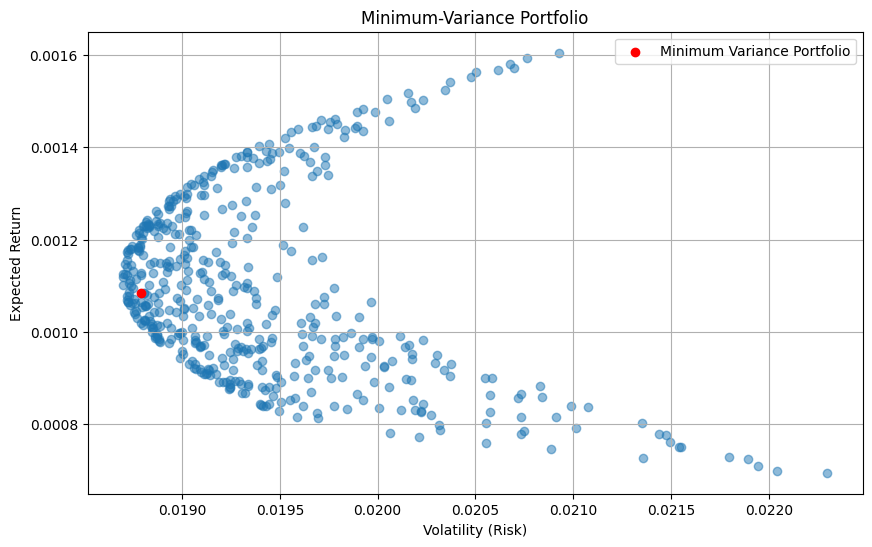

Minimum Variance Portfolio:
Weights: [0.33333333 0.33333333 0.33333333]
Expected Return: 0.0010843609173264964
Volatility: 0.018790403102529944


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tickers = ['AAPL', 'GOOGL', 'AMZN']
df = yf.download(tickers, start='2019-01-01')['Adj Close']
returns = df.pct_change(1).dropna()

# 공분산 행렬 계산
cov_matrix = returns.cov()

# 포트폴리오 종목 비중 초기화: uniform weights로
num_assets = len(returns.columns)
weights = np.ones(num_assets) / num_assets

# 최적화 함수로 최소 분산 포트폴리오 계산
from scipy.optimize import minimize

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 비중 합계는 1
bounds = tuple((0, 1) for _ in range(num_assets))  # 각 비중은 0과 1 사이

result = minimize(portfolio_variance, weights, args=(cov_matrix,),
                  method='SLSQP', constraints=constraints, bounds=bounds)

optimal_weights = result.x
min_variance = result.fun

# 최소 분산 포트폴리오 수익률 계산
expected_returns = returns.mean()
min_portfolio_return = np.dot(expected_returns, optimal_weights)

# 포트폴리오 시뮬레이션
n_simulations = 500
returns_simulated = np.zeros(n_simulations)
volatility_simulated = np.zeros(n_simulations)

for i in range(n_simulations):
    weights_simulated = np.random.dirichlet(np.ones(num_assets), size=1).flatten()
    returns_simulated[i] = np.dot(expected_returns, weights_simulated)
    volatility_simulated[i] = np.sqrt(portfolio_variance(weights_simulated, cov_matrix))

# 최소 분산 포트폴리오 그래프
plt.figure(figsize=(10, 6))
plt.scatter(volatility_simulated, returns_simulated, marker='o', alpha=0.5)
plt.scatter(np.sqrt(min_variance), min_portfolio_return, marker='o', color='red', label='Minimum Variance Portfolio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.title('Minimum-Variance Portfolio')
plt.legend()
plt.grid(True)
plt.show()

# Print minimum variance portfolio details
print('Minimum Variance Portfolio:')
print('Weights:', optimal_weights)
print('Expected Return:', min_portfolio_return)
print('Volatility:', np.sqrt(min_variance))

[*********************100%***********************]  3 of 3 completed


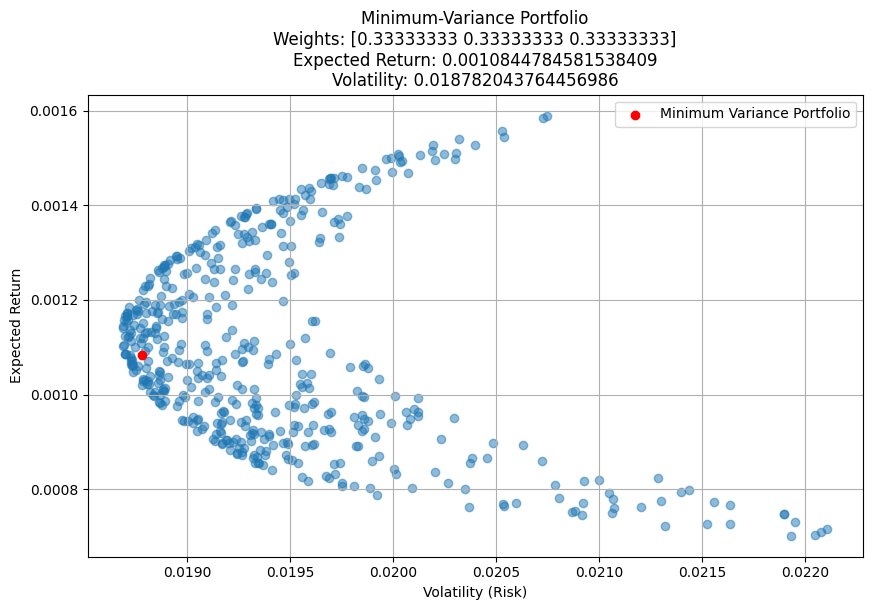

In [17]:
# 위 코드에서 plt.title 부분만 수정했다:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tickers = ['AAPL', 'GOOGL', 'AMZN']
df = yf.download(tickers, start='2019-01-01')['Adj Close']
returns = df.pct_change(1).dropna()

# 공분산 행렬 계산
cov_matrix = returns.cov()

# 포트폴리오 종목 비중 초기화: uniform weights로
num_assets = len(returns.columns)
weights = np.ones(num_assets) / num_assets

# 최적화 함수로 최소 분산 포트폴리오 계산
from scipy.optimize import minimize

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 비중 합계는 1
bounds = tuple((0, 1) for _ in range(num_assets))  # 각 비중은 0과 1 사이

result = minimize(portfolio_variance, weights, args=(cov_matrix,),
                  method='SLSQP', constraints=constraints, bounds=bounds)

optimal_weights = result.x
min_variance = result.fun

# 최소 분산 포트폴리오 수익률 계산
expected_returns = returns.mean()
min_portfolio_return = np.dot(expected_returns, optimal_weights)

# 포트폴리오 시뮬레이션
n_simulations = 500
returns_simulated = np.zeros(n_simulations)
volatility_simulated = np.zeros(n_simulations)

for i in range(n_simulations):
    weights_simulated = np.random.dirichlet(np.ones(num_assets), size=1).flatten()
    returns_simulated[i] = np.dot(expected_returns, weights_simulated)
    volatility_simulated[i] = np.sqrt(portfolio_variance(weights_simulated, cov_matrix))

# 최소 분산 포트폴리오 그래프
plt.figure(figsize=(10, 6))
plt.scatter(volatility_simulated, returns_simulated, marker='o', alpha=0.5)
plt.scatter(np.sqrt(min_variance), min_portfolio_return, marker='o', color='red', label='Minimum Variance Portfolio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')

# 수정된 부분: optimal_weights, min_portfolio_return, np.sqrt(min_variance) 출력
title = f"Minimum-Variance Portfolio\nWeights: {optimal_weights}\nExpected Return: {min_portfolio_return}\nVolatility: {np.sqrt(min_variance)}"
plt.title(title)

plt.legend()
plt.grid(True)
plt.show()

[*********************100%***********************]  3 of 3 completed


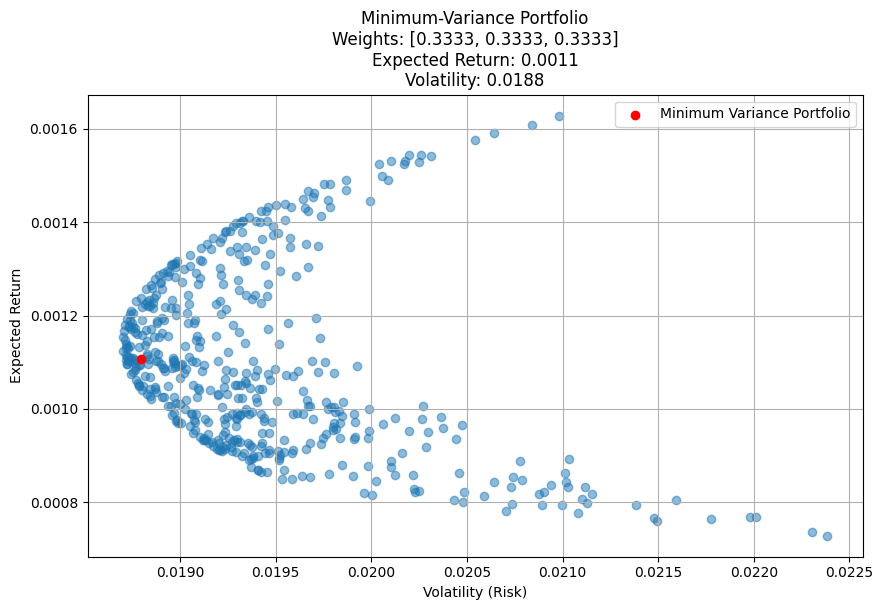

In [19]:
# 다시 위 코드에서 title에 출력될 변수들을 소수점 네자리까지만 고려
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tickers = ['AAPL', 'GOOGL', 'AMZN']
df = yf.download(tickers, start='2019-01-01')['Adj Close']
returns = df.pct_change(1).dropna()

# 공분산 행렬 계산
cov_matrix = returns.cov()

# 포트폴리오 종목 비중 초기화: uniform weights로
num_assets = len(returns.columns)
weights = np.ones(num_assets) / num_assets

# 최적화 함수로 최소 분산 포트폴리오 계산
from scipy.optimize import minimize

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 비중 합계는 1
bounds = tuple((0, 1) for _ in range(num_assets))  # 각 비중은 0과 1 사이

result = minimize(portfolio_variance, weights, args=(cov_matrix,),
                  method='SLSQP', constraints=constraints, bounds=bounds)

optimal_weights = result.x
min_variance = result.fun

# 최소 분산 포트폴리오 수익률 계산
expected_returns = returns.mean()
min_portfolio_return = np.dot(expected_returns, optimal_weights)

# 포트폴리오 시뮬레이션
n_simulations = 500
returns_simulated = np.zeros(n_simulations)
volatility_simulated = np.zeros(n_simulations)

for i in range(n_simulations):
    weights_simulated = np.random.dirichlet(np.ones(num_assets), size=1).flatten()
    returns_simulated[i] = np.dot(expected_returns, weights_simulated)
    volatility_simulated[i] = np.sqrt(portfolio_variance(weights_simulated, cov_matrix))

# 최소 분산 포트폴리오 그래프
plt.figure(figsize=(10, 6))
plt.scatter(volatility_simulated, returns_simulated, marker='o', alpha=0.5)
plt.scatter(np.sqrt(min_variance), min_portfolio_return, marker='o', color='red', label='Minimum Variance Portfolio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')

# 수정된 부분: optimal_weights, min_portfolio_return, np.sqrt(min_variance) 소수점 아래 4자리 출력
optimal_weights_rounded = [round(weight, 4) for weight in optimal_weights]
min_portfolio_return_rounded = round(min_portfolio_return, 4)
min_variance_rounded = round(np.sqrt(min_variance), 4)
title = f"Minimum-Variance Portfolio\nWeights: {optimal_weights_rounded}\nExpected Return: {min_portfolio_return_rounded}\nVolatility: {min_variance_rounded}"
plt.title(title)
plt.legend()
plt.grid(True)
plt.show()

위 코드를 tickers, start_date, end_date와 n_simulations를 input으로 받고

위 Minimum Variance portfolio와 임의의 weights들에 대한 포트폴리오들을 plot시킨 그래프를 전부 출력시키는 함수로 만들자:

[*********************100%***********************]  5 of 5 completed


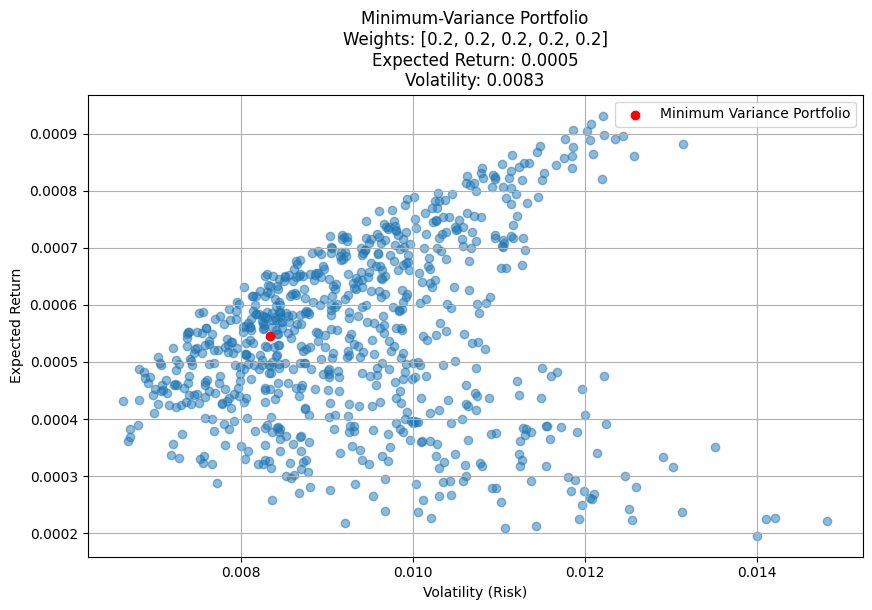

In [29]:
# Minimum Variance portfolio와 임의의 weights들에 대한 포트폴리오들을 plot시킨 그래프를 전부 출력시키는 함수
def plot_MVP(tickers, start_date, end_date, n_simulations):
    df = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    returns = df.pct_change(1).dropna()

    # 공분산 행렬 계산
    cov_matrix = returns.cov()

    # 포트폴리오 종목 비중 초기화: uniform weights로
    num_assets = len(returns.columns)
    weights = np.ones(num_assets) / num_assets

    # 최적화 함수로 최소 분산 포트폴리오 계산
    from scipy.optimize import minimize

    def portfolio_variance(weights, cov_matrix):
        return np.dot(weights.T, np.dot(cov_matrix, weights))

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 비중 합계는 1
    bounds = tuple((0, 1) for _ in range(num_assets))  # 각 비중은 0과 1 사이

    result = minimize(portfolio_variance, weights, args=(cov_matrix,),
                    method='SLSQP', constraints=constraints, bounds=bounds)

    optimal_weights = result.x
    min_variance = result.fun

    # 최소 분산 포트폴리오 수익률 계산
    expected_returns = returns.mean()
    min_portfolio_return = np.dot(expected_returns, optimal_weights)

    # 포트폴리오 시뮬레이션
    # n_points = 500
    returns_simulated = np.zeros(n_simulations)
    volatility_simulated = np.zeros(n_simulations)

    for i in range(n_simulations):
        weights_simulated = np.random.dirichlet(np.ones(num_assets), size=1).flatten()
        returns_simulated[i] = np.dot(expected_returns, weights_simulated)
        volatility_simulated[i] = np.sqrt(portfolio_variance(weights_simulated, cov_matrix))

    # 최소 분산 포트폴리오 그래프
    plt.figure(figsize=(10, 6))
    plt.scatter(volatility_simulated, returns_simulated, marker='o', alpha=0.5)
    plt.scatter(np.sqrt(min_variance), min_portfolio_return, marker='o', color='red', label='Minimum Variance Portfolio')
    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Expected Return')

    # 수정된 부분: optimal_weights, min_portfolio_return, np.sqrt(min_variance) 소수점 아래 4자리 출력
    optimal_weights_rounded = [round(weight, 4) for weight in optimal_weights]
    min_portfolio_return_rounded = round(min_portfolio_return, 4)
    min_variance_rounded = round(np.sqrt(min_variance), 4)
    title = f"Minimum-Variance Portfolio\nWeights: {optimal_weights_rounded}\nExpected Return: {min_portfolio_return_rounded}\nVolatility: {min_variance_rounded}"
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

tickers = ['GLD', 'SLV', 'AAPL', 'MSFT', 'KO']
start_date = '2010-01-01'
end_date = '2020-02-01'
n_simulations = 750
plot_MVP(tickers, start_date, end_date, n_simulations)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tickers = ['AAPL', 'GOOGL', 'AMZN']
df = yf.download(tickers, start='2019-01-01')['Adj Close']
returns = df.pct_change(1).dropna()

ret_portf, ret_vol = [], []
num_simulations = 500
num_assets

for _ in range(num_simulations):
    w = np.random.rand(num)

plt.scatter(ret_portf, )

In [ ]:
# 공분산 행렬 계산
cov_matrix = returns.cov()

# 포트폴리오 종목 비중 초기화: uniform weights로
num_assets = len(returns.columns)
weights = np.ones(num_assets) / num_assets

# 최적화 함수로 최소 분산 포트폴리오 계산
from scipy.optimize import minimize

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 비중 합계는 1
bounds = tuple((0, 1) for _ in range(num_assets))  # 각 비중은 0과 1 사이

result = minimize(portfolio_variance, weights, args=(cov_matrix,),
                  method='SLSQP', constraints=constraints, bounds=bounds)

optimal_weights = result.x
min_variance = result.fun

# 최소 분산 포트폴리오 수익률 계산
expected_returns = returns.mean()
min_portfolio_return = np.dot(expected_returns, optimal_weights)

# 포트폴리오 시뮬레이션
n_simulations = 500
returns_simulated = np.zeros(n_simulations)
volatility_simulated = np.zeros(n_simulations)

for i in range(n_simulations):
    weights_simulated = np.random.dirichlet(np.ones(num_assets), size=1).flatten()
    returns_simulated[i] = np.dot(expected_returns, weights_simulated)
    volatility_simulated[i] = np.sqrt(portfolio_variance(weights_simulated, cov_matrix))

# 최소 분산 포트폴리오 그래프
plt.figure(figsize=(10, 6))
plt.scatter(volatility_simulated, returns_simulated, marker='o', alpha=0.5)
plt.scatter(np.sqrt(min_variance), min_portfolio_return, marker='o', color='red', label='Minimum Variance Portfolio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')

# 수정된 부분: optimal_weights, min_portfolio_return, np.sqrt(min_variance) 소수점 아래 4자리 출력
optimal_weights_rounded = [round(weight, 4) for weight in optimal_weights]
min_portfolio_return_rounded = round(min_portfolio_return, 4)
min_variance_rounded = round(np.sqrt(min_variance), 4)
title = f"Minimum-Variance Portfolio\nWeights: {optimal_weights_rounded}\nExpected Return: {min_portfolio_return_rounded}\nVolatility: {min_variance_rounded}"
plt.title(title)
plt.legend()
plt.grid(True)
plt.show()